In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2
%cd ..

/workspace/lung-segmentation


In [2]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms

from src.data.utils import simple_collate_fn
from src.data import NSCLCDataset
from src.models.unet import UNet
from src.visualization import plot_batch, plot_true_vs_pred
from src.preprocess import DEFAULT_TRANSFORM

In [3]:
device = "cuda:1"
from src.models.unet import UNet
#summary(net.to("cuda:0"), input_size=(1, 256, 256), batch_size=16)
net = UNet.load_from_checkpoint("lightning_logs/version_1/checkpoints/epoch=18.ckpt")
net.to(device).eval();

In [10]:
train_ds = NSCLCDataset(                             
    metadata_path="data/processed/NSCLC-Radiomics_train_metadata.pkl",
    transform=DEFAULT_TRANSFORM,                                                       
)                                                              
val_ds = NSCLCDataset(                  
    metadata_path="data/processed/NSCLC-Radiomics_val_metadata.pkl",
    transform=DEFAULT_TRANSFORM,                                        
)                                       
# using smaller subsets for now            
#train_ds_sm = Subset(train_ds, range(5000))                     
#val_ds_sm = Subset(train_ds, range(5000, 6000)) 

loader = DataLoader(val_ds, batch_size=6, shuffle=True,
                    collate_fn=simple_collate_fn)
X_test, y_test = next(iter(loader))
with torch.no_grad():
    preds = net(X_test.to(device))
    pred_masks = torch.argmax(preds, dim=1)
    pred_masks = pred_masks.cpu()

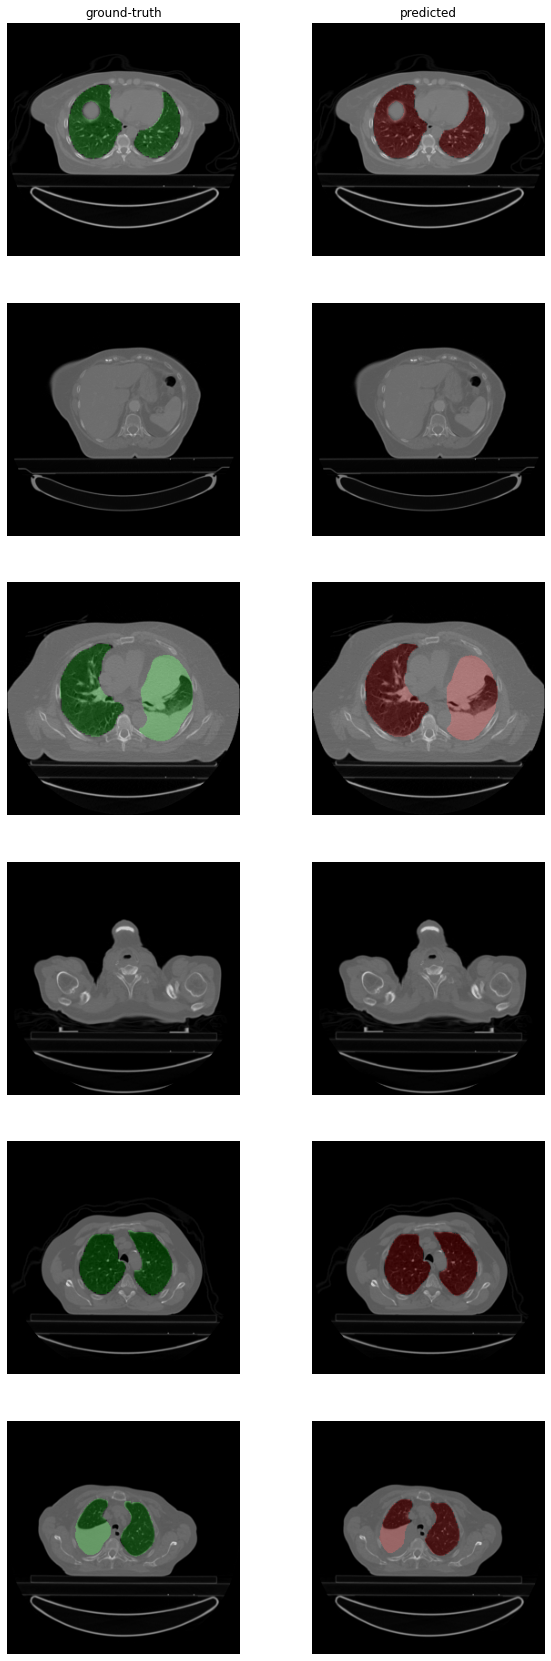

In [11]:
plot_true_vs_pred(X_test, y_test, pred_masks,
                  mask_alpha=0.2)

In [27]:
pred_masks.sum()

tensor(0)